# 3-2,中阶API示范

下面的范例使用Pytorch的中阶API实现线性回归模型和和DNN二分类模型。

Pytorch的中阶API主要包括各种模型层，损失函数，优化器，数据管道等等。

In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 
from python_cgtools.utils_date import *
from python_cgtools.utils_torch import *

torch.__version__ =  2.0.1+cu118
tensorboard.__version__ =  2.13.0
torchvision.__version__ =  0.15.2+cu118
pytorch_lightning.__version__ =  2.0.2
torchtext.__version__ =  0.15.2
torchdata.__version__ =  0.6.1
torchmetrics.__version__ =  0.11.4
torchkeras.__version__ =  3.8.2
yaml.__version__ =  6.0
tensorflow sed random seed fail.


In [2]:
start_time = time.time()
print_with_time("start.........")

2023-05-29 13:27:52:start.........


### 一，线性回归模型

**1，准备数据**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动


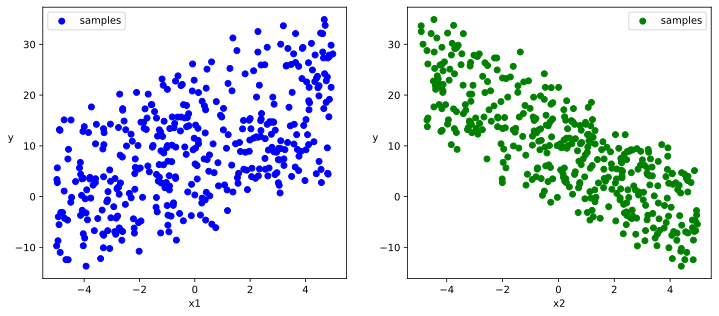

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


![](./data/3-2-线性回归数据可视化.png)

In [5]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,
                num_workers=0)



**2，定义模型**

In [6]:
model = nn.Linear(2,1) #线性层

model.loss_fn = nn.MSELoss()
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)




**3，训练模型**

In [7]:
def train_step(model, features, labels):
    
    predictions = model(features)
    loss = model.loss_fn(predictions,labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad() # 注意，新手常常遗忘该步骤
    return loss.item()

# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)



197.79226684570312

```
269.98016357421875
```

In [8]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in dl:
            loss = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            w = model.state_dict()["weight"]
            b = model.state_dict()["bias"]
            print("epoch =",epoch,"loss = ",loss)
            print("w =",w)
            print("b =",b)
train_model(model,epochs = 50)



================================================================================2023-05-29 13:27:52
epoch = 10 loss =  5.3903350830078125
w = tensor([[ 2.0971, -2.9648]])
b = tensor([10.0488])

================================================================================2023-05-29 13:27:53
epoch = 20 loss =  6.162847995758057
w = tensor([[ 2.0308, -3.1261]])
b = tensor([10.0587])

================================================================================2023-05-29 13:27:53
epoch = 30 loss =  2.687321424484253
w = tensor([[ 1.9964, -2.9296]])
b = tensor([10.0596])

================================================================================2023-05-29 13:27:53
epoch = 40 loss =  1.4758201837539673
w = tensor([[ 2.0693, -2.9972]])
b = tensor([10.0643])

================================================================================2023-05-29 13:27:53
epoch = 50 loss =  3.9055511951446533
w = tensor([[ 2.0220, -3.0233]])
b = tensor([10.0421])


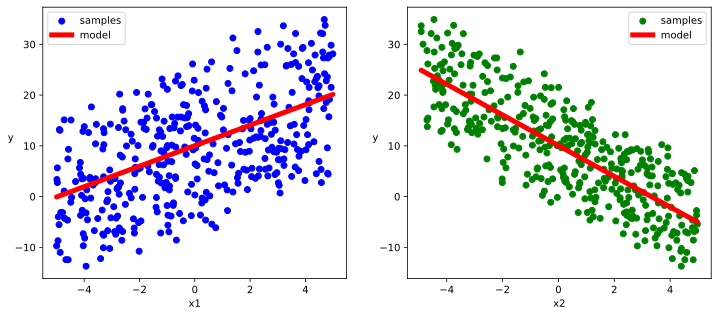

In [9]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.state_dict()["weight"],model.state_dict()["bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


### 二， DNN二分类模型

**1，准备数据**

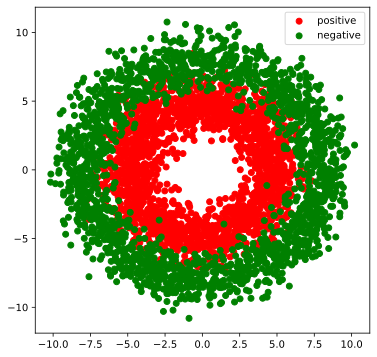

In [10]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


In [11]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=0)



**2, 定义模型**

In [12]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)

    # 正向传播
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
    
    # 损失函数
    def loss_fn(self,y_pred,y_true):
        return nn.BCELoss()(y_pred,y_true)
    
    # 评估函数(准确率)
    def metric_fn(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
    # 优化器
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(),lr = 0.001)
    
model = DNNModel()


In [13]:
# 测试模型结构
(features,labels) = next(iter(dl))
predictions = model(features)

loss = model.loss_fn(predictions,labels)
metric = model.metric_fn(predictions,labels)

print("init loss:",loss.item())
print("init metric:",metric.item())


init loss: 0.82405024766922
init metric: 0.4000000059604645


```
init loss: 0.7065666913986206
init metric: 0.6000000238418579
```

**3，训练模型**

In [14]:
def train_step(model, features, labels):
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_fn(predictions,labels)
    metric = model.metric_fn(predictions,labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 更新模型参数
    model.optimizer.step()
    model.optimizer.zero_grad()
    
    return loss.item(),metric.item()

# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)


(0.8433123826980591, 0.4000000059604645)

```
(0.6048880815505981, 0.699999988079071)
```

In [15]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in dl:
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%10==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 50)


================================================================================2023-05-29 13:27:58
epoch = 10 loss =  0.24004610433243215 metric =  0.905749992057681

================================================================================2023-05-29 13:28:02
epoch = 20 loss =  0.21424591110670008 metric =  0.9094999918341636

================================================================================2023-05-29 13:28:06
epoch = 30 loss =  0.21361404968192801 metric =  0.911999991685152

================================================================================2023-05-29 13:28:11
epoch = 40 loss =  0.21538441262964625 metric =  0.9154999934136867

================================================================================2023-05-29 13:28:15
epoch = 50 loss =  0.21930436812122933 metric =  0.9162499922513961


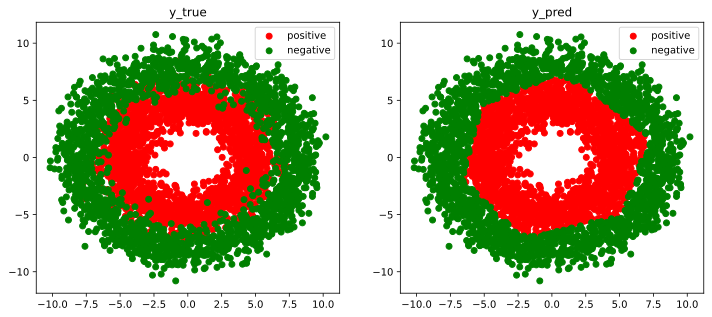

In [16]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)